<a href="https://colab.research.google.com/github/KwonYN/TIL/blob/master/PYTHON/TENSORFLOW/Ch4_%EC%98%88%EC%A0%9C_07_CNN_MNIST_3_Conv_Layer_ReLU_Dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Chapter4-2. CNN 기본연산

## [예제7] MNIST Handwrite - Classifier by CNN : 3 Convolution Layer - ReLU, Dropout 사용

> ### Load Module

In [1]:
%tensorflow_version 1.x

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import mnist

print("Module Loaded.")
print("NumPy Version :{}".format(np.__version__))
print("TensorFlow Version :{}".format(tf.__version__))
print("Matplotlib Version :{}".format(plt.matplotlib.__version__))

Module Loaded.
NumPy Version :1.17.4
TensorFlow Version :1.15.0
Matplotlib Version :3.1.2


> ### Load MNIST 

In [2]:
categories = 10

(train_data, train_labels), (test_data, test_labels) = mnist.load_data()
train_data_size = train_data.shape

train_data = train_data.astype(np.float32)
train_data = np.expand_dims(train_data, axis = -1)
train_data = train_data / 255.0

test_data = test_data.astype(np.float32)
test_data = np.expand_dims(test_data, axis = -1)
test_data = test_data / 255.0

train_labels = train_labels.reshape((-1, 1))
test_labels = test_labels.reshape((-1, 1))

11493376/11490434 [==============================] - 0s 0us/step


> ### Hyper parameter

In [0]:
learning_rate = 0.001

N_epoch = 100
batch_size = 1000
training_do_rate = 0.5
batch_count = train_data_size[0]//batch_size

> ### Placeholder

In [0]:
x_ph = tf.placeholder(tf.float32, shape=(None, 28, 28, 1), name="input")
labels_ph = tf.placeholder(tf.int32, shape=(None, 1), name="labels")
do_rate_ph = tf.placeholder(tf.float32, shape=(), name="Dropout_rate")

> ### Define Network as function : in this function, "Dropout"



In [0]:
def network(x, rate):

  conv1 = tf.layers.conv2d(x, filters=32, kernel_size=3, padding='SAME', activation=tf.nn.relu) # instead of sigmoid, use "ReLU"
  conv1_do = tf.layers.dropout(conv1, rate=rate)  # instead of batch normalization, use "Dropout"
  pool1 = tf.layers.max_pooling2d(conv1_do, pool_size=[2, 2], strides=[2, 2])

  conv2 = tf.layers.conv2d(pool1, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
  conv2_do = tf.layers.dropout(conv2, rate=rate)
  pool2 = tf.layers.max_pooling2d(conv2_do, pool_size=[2, 2], strides=[2, 2])

  conv3 = tf.layers.conv2d(pool2, filters=64, kernel_size=3, padding='SAME', activation=tf.nn.relu)
  conv3_do = tf.layers.dropout(conv3, rate=rate)
  pool3 = tf.layers.max_pooling2d(conv3_do, pool_size=[2, 2], strides=[2, 2])

  flatten = tf.layers.flatten(pool3)
  logits = tf.layers.dense(flatten, 10)
  hypothesis = tf.nn.softmax(logits)

  return pool1, pool2, pool3,logits, hypothesis

> ### Hypothesis, Cost, Optimizer

In [6]:
pool1, pool2, pool3, logits, hypothesis = network(x_ph, do_rate_ph)
labels_oh = tf.one_hot(labels_ph, categories)
cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels_oh, logits))

optimizer = tf.train.AdamOptimizer(learning_rate)
train = optimizer.minimize(cost)

Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.MaxPooling2D instead.
Instructions for updating:
Use keras.layers.flatten instead.
Instructions for updating:
Use keras.layers.Dense instead.


> ### Accuracy, Plotting

In [0]:
def Accuracy(y:np.ndarray, t:np.ndarray)->np.float32:
    return np.mean(np.equal(np.argmax(y, axis=1).reshape((-1, 1)),t).astype(np.float32))


def Make_Result_Plot(suptitle:str, data:np.ndarray, label:np.ndarray, y_max:np.ndarray):
    fig_result, ax_result = plt.subplots(2,5,figsize=(20,8))
    fig_result.suptitle(suptitle)
    for idx in range(10):
        ax_result[idx//5][idx%5].imshow(data[idx].reshape(28, 28),cmap="binary")
        ax_result[idx//5][idx%5].set_title("test_data[{}] (label : {} / y : {})".format(idx, label[idx], y_max[idx]))

def Make_False_Result_Plot(suptitle:str, data:np.ndarray, label:np.ndarray, y_max:np.ndarray):
    false_arr = []
    for idx in range(len(label)):
      if label[idx] != y_max[idx]:
        false_arr.append(idx)
    np.random.shuffle(false_arr)

    fig_result, ax_result = plt.subplots(2, 5,figsize=(20,8))
    fig_result.suptitle(suptitle)

    for idx in range(len(false_arr)):
      if idx >= 10: break
      ax_result[idx//5][idx%5].imshow(data[false_arr[idx]].reshape(28, 28),cmap="binary")
      ax_result[idx//5][idx%5].set_title("false_arr[{}] (label : {} / y : {})".format(idx, label[false_arr[idx]], y_max[false_arr[idx]]))
    print(len(false_arr))


> ### Training 준비

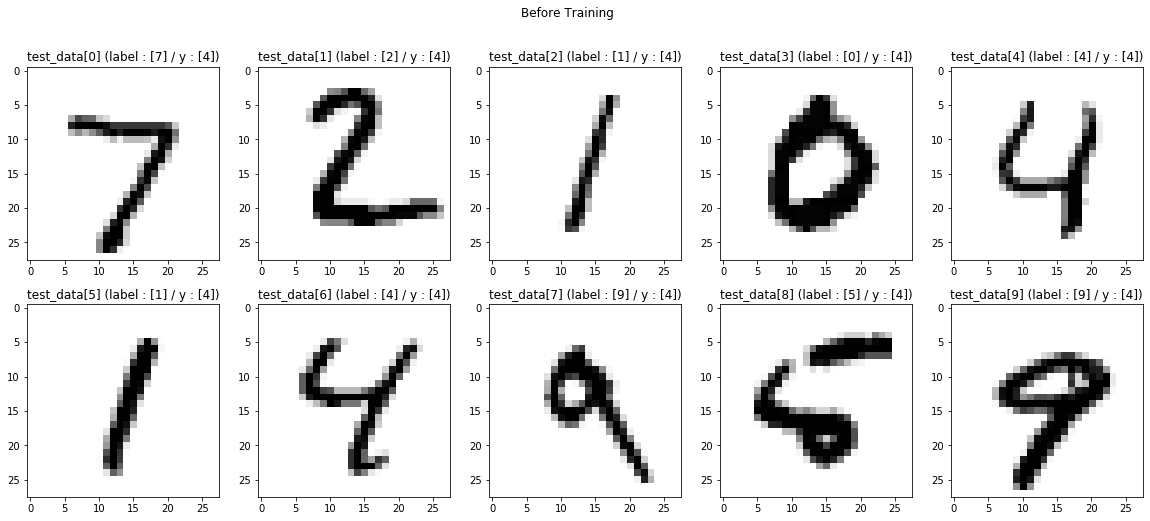

In [8]:
arr_epoch = []
arr_accu = []

# 학습 (Training)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

train_data_idx = np.arange(train_data_size[0])

y_out = sess.run(hypothesis, feed_dict={x_ph: test_data, do_rate_ph: 0.0})
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("Before Training", test_data, test_labels, y_max)

accu = Accuracy(y_out,test_labels)
arr_epoch.append(0)
arr_accu.append(accu)

> ### Training

In [9]:
%%time
for epoch_idx in range(1, N_epoch+1):
    np.random.shuffle(train_data_idx)
    for batch_idx in range(batch_count):
        batch_data = np.array([train_data[train_data_idx[batch_idx*batch_size+idx]] for idx in range(batch_size)])
        batch_labels = np.array([train_labels[train_data_idx[batch_idx*batch_size+idx]] for idx in range(batch_size)])
        sess.run(train, feed_dict={x_ph: batch_data, labels_ph: batch_labels,do_rate_ph: training_do_rate})
    if epoch_idx%1 == 0:
        y_out = sess.run(hypothesis, feed_dict={x_ph: test_data, do_rate_ph: 0.0})
        accu = Accuracy(y_out,test_labels)
        print("[{:>5}] accuracy = {:>10.4}".format(epoch_idx,accu))
        arr_epoch.append(epoch_idx)
        arr_accu.append(accu)

[    1] accuracy =     0.9459
[    2] accuracy =     0.9676
[    3] accuracy =     0.9758
[    4] accuracy =     0.9821
[    5] accuracy =     0.9854
[    6] accuracy =     0.9859
[    7] accuracy =     0.9884
[    8] accuracy =      0.989
[    9] accuracy =     0.9893
[   10] accuracy =     0.9897
[   11] accuracy =     0.9904
[   12] accuracy =     0.9893
[   13] accuracy =       0.99
[   14] accuracy =      0.991
[   15] accuracy =     0.9911
[   16] accuracy =     0.9911
[   17] accuracy =     0.9891
[   18] accuracy =     0.9913
[   19] accuracy =     0.9892
[   20] accuracy =     0.9905
[   21] accuracy =     0.9905
[   22] accuracy =     0.9905
[   23] accuracy =     0.9906
[   24] accuracy =      0.991
[   25] accuracy =     0.9912
[   26] accuracy =     0.9914
[   27] accuracy =      0.991
[   28] accuracy =     0.9909
[   29] accuracy =     0.9912
[   30] accuracy =     0.9892
[   31] accuracy =     0.9911
[   32] accuracy =     0.9908
[   33] accuracy =     0.9899
[   34] ac

83


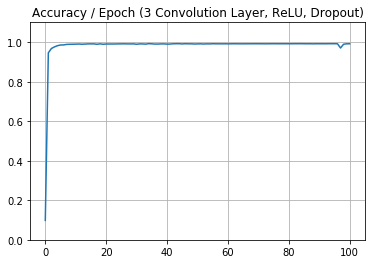

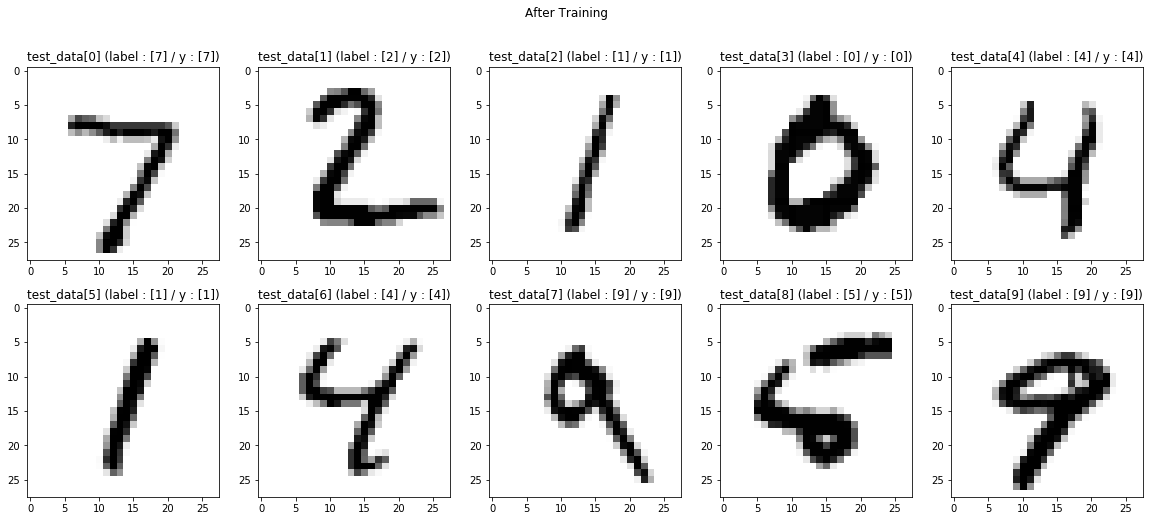

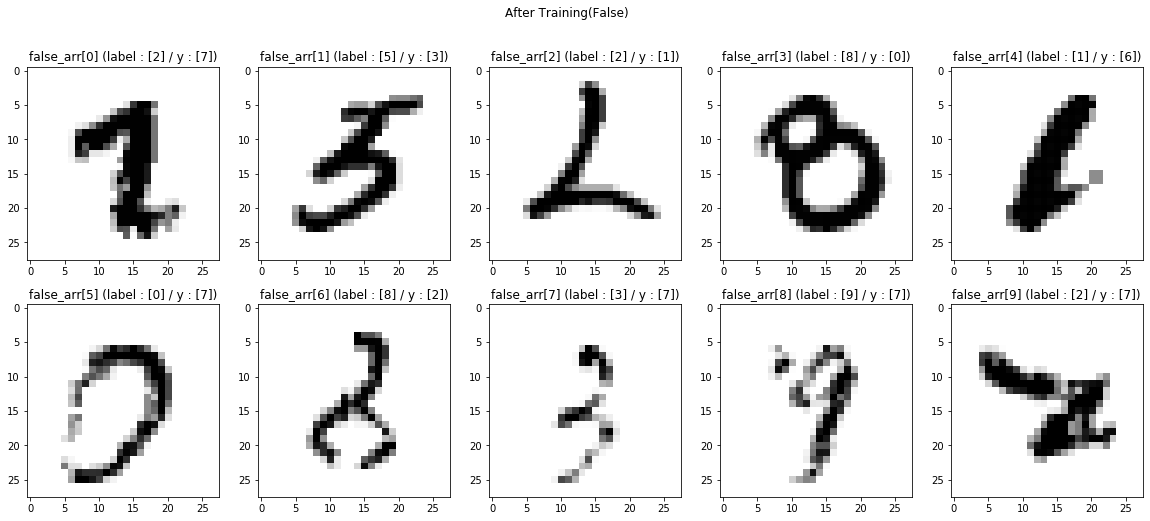

In [16]:
# Plot : Accuracy / Epoch
fig_cost, ax_cost = plt.subplots()
ax_cost.plot(arr_epoch, arr_accu)
ax_cost.set_title("Accuracy / Epoch (3 Convolution Layer, ReLU, Dropout)")
ax_cost.grid(True)
ax_cost.set_ylim(0,1.1)

y_out = sess.run(hypothesis, feed_dict={x_ph: test_data})
y_max = np.argmax(y_out, axis=1).reshape((-1, 1))
Make_Result_Plot("After Training", test_data, test_labels, y_max)
Make_False_Result_Plot("After Training(False)", test_data, test_labels, y_max)

plt.show()

> ### 1차 Convolution Layer의 결과물 : 저차원 feature map

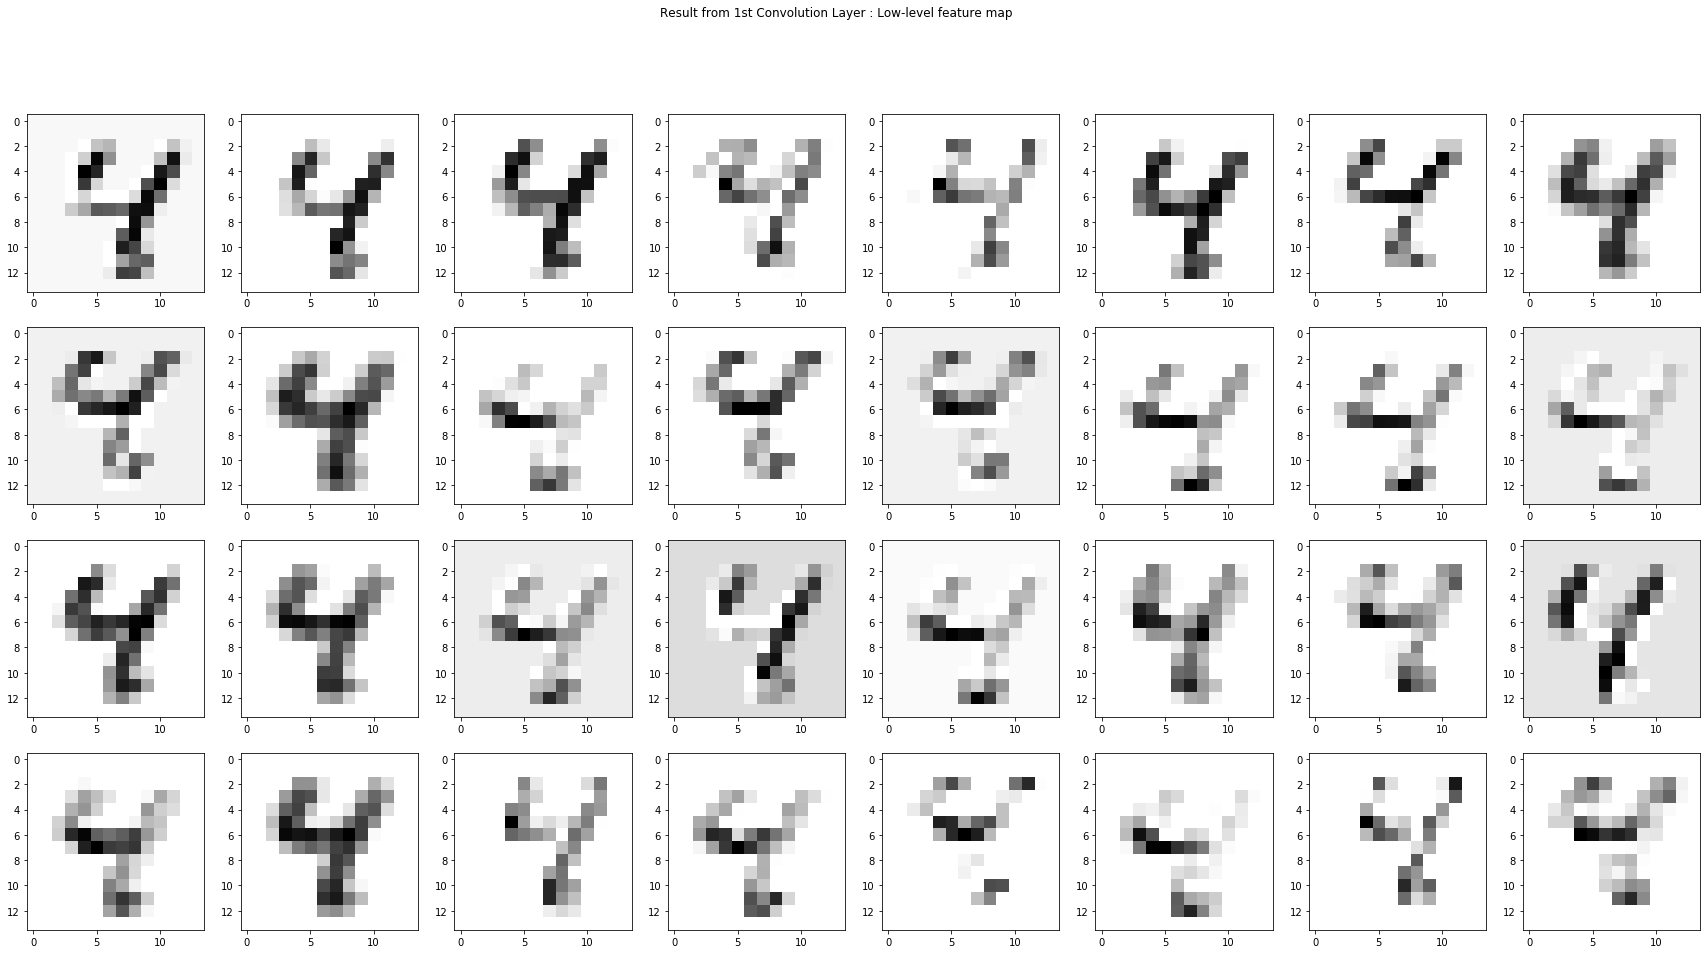

In [11]:
sample_test_data = [test_data[6]]
ret_pool1,ret_pool2,ret_pool3 = sess.run((pool1,pool2,pool3), feed_dict={x_ph: sample_test_data,do_rate_ph: 0.0}) 

fig_feature1, ax_feature1 = plt.subplots(4,8,figsize=(30,15))
fig_feature1.suptitle("Result from 1st Convolution Layer : Low-level feature map")
ret_pool1 = np.transpose(ret_pool1,axes=(0,3,1,2))
for idx in range(32):
  ax_feature1[idx//8][idx%8].imshow(ret_pool1[0][idx],cmap="binary")

> ### 2차 Convolution Layer의 결과물

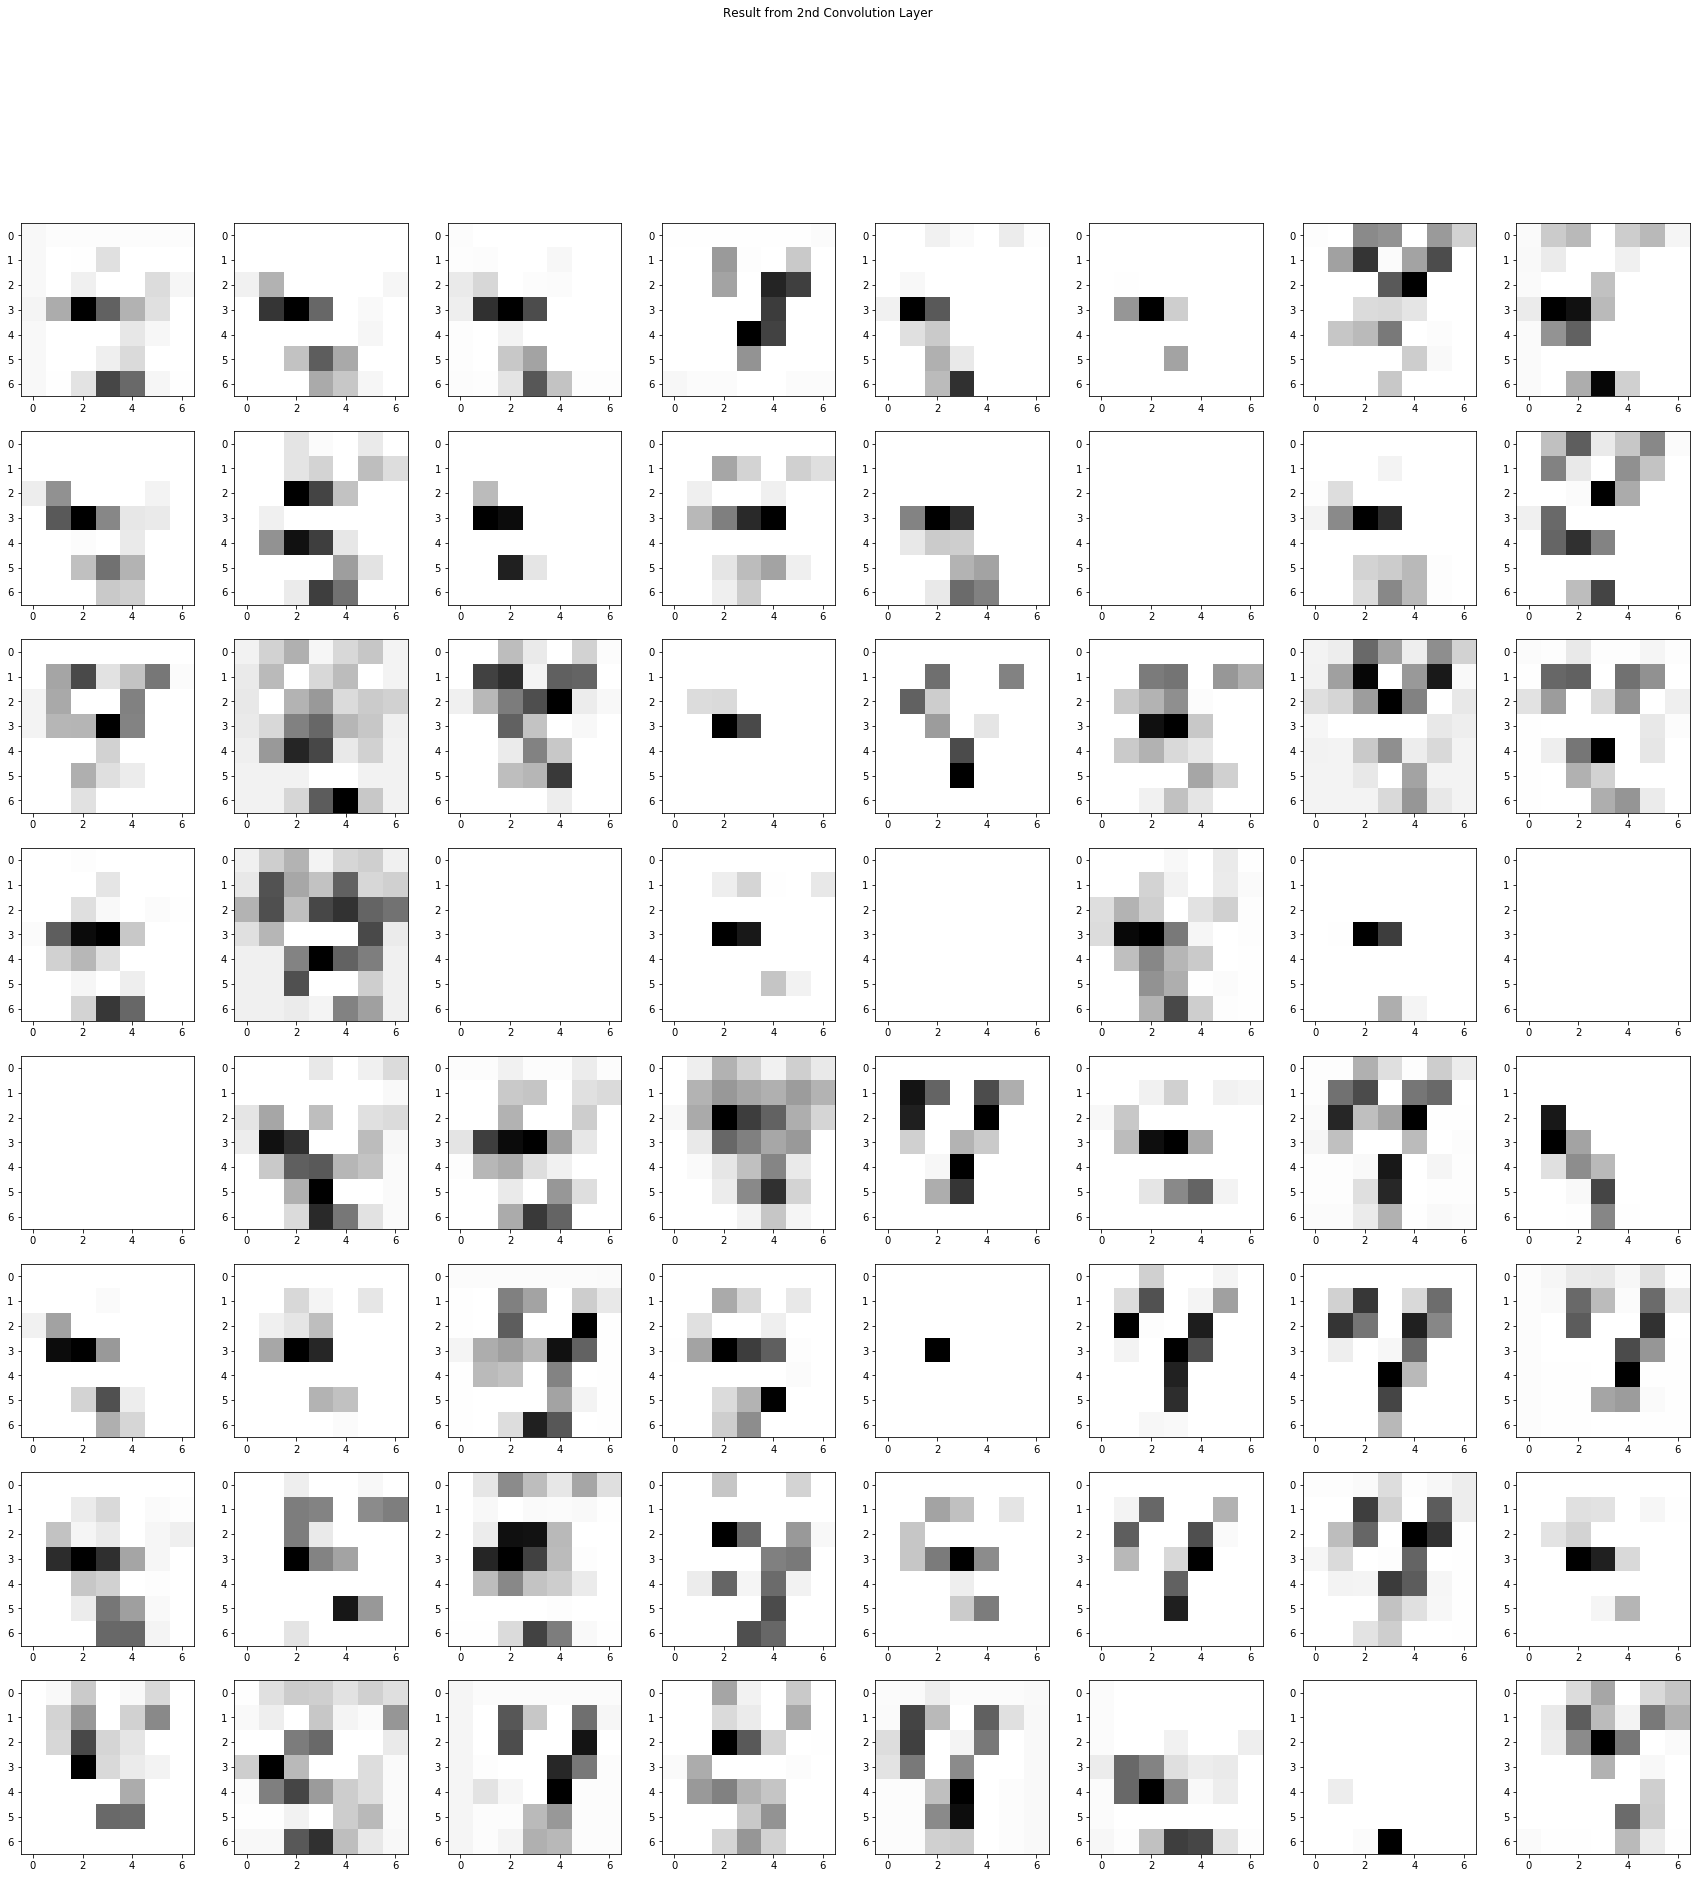

In [12]:
fig_feature2, ax_feature2 = plt.subplots(8,8,figsize=(30,30))
fig_feature2.suptitle("Result from 2nd Convolution Layer")
ret_pool2 = np.transpose(ret_pool2,axes=(0,3,1,2))
for idx in range(64):
  ax_feature2[idx//8][idx%8].imshow(ret_pool2[0][idx],cmap="binary")

> ### 3차 Convolution Layer의 결과물 : 고차원 feature

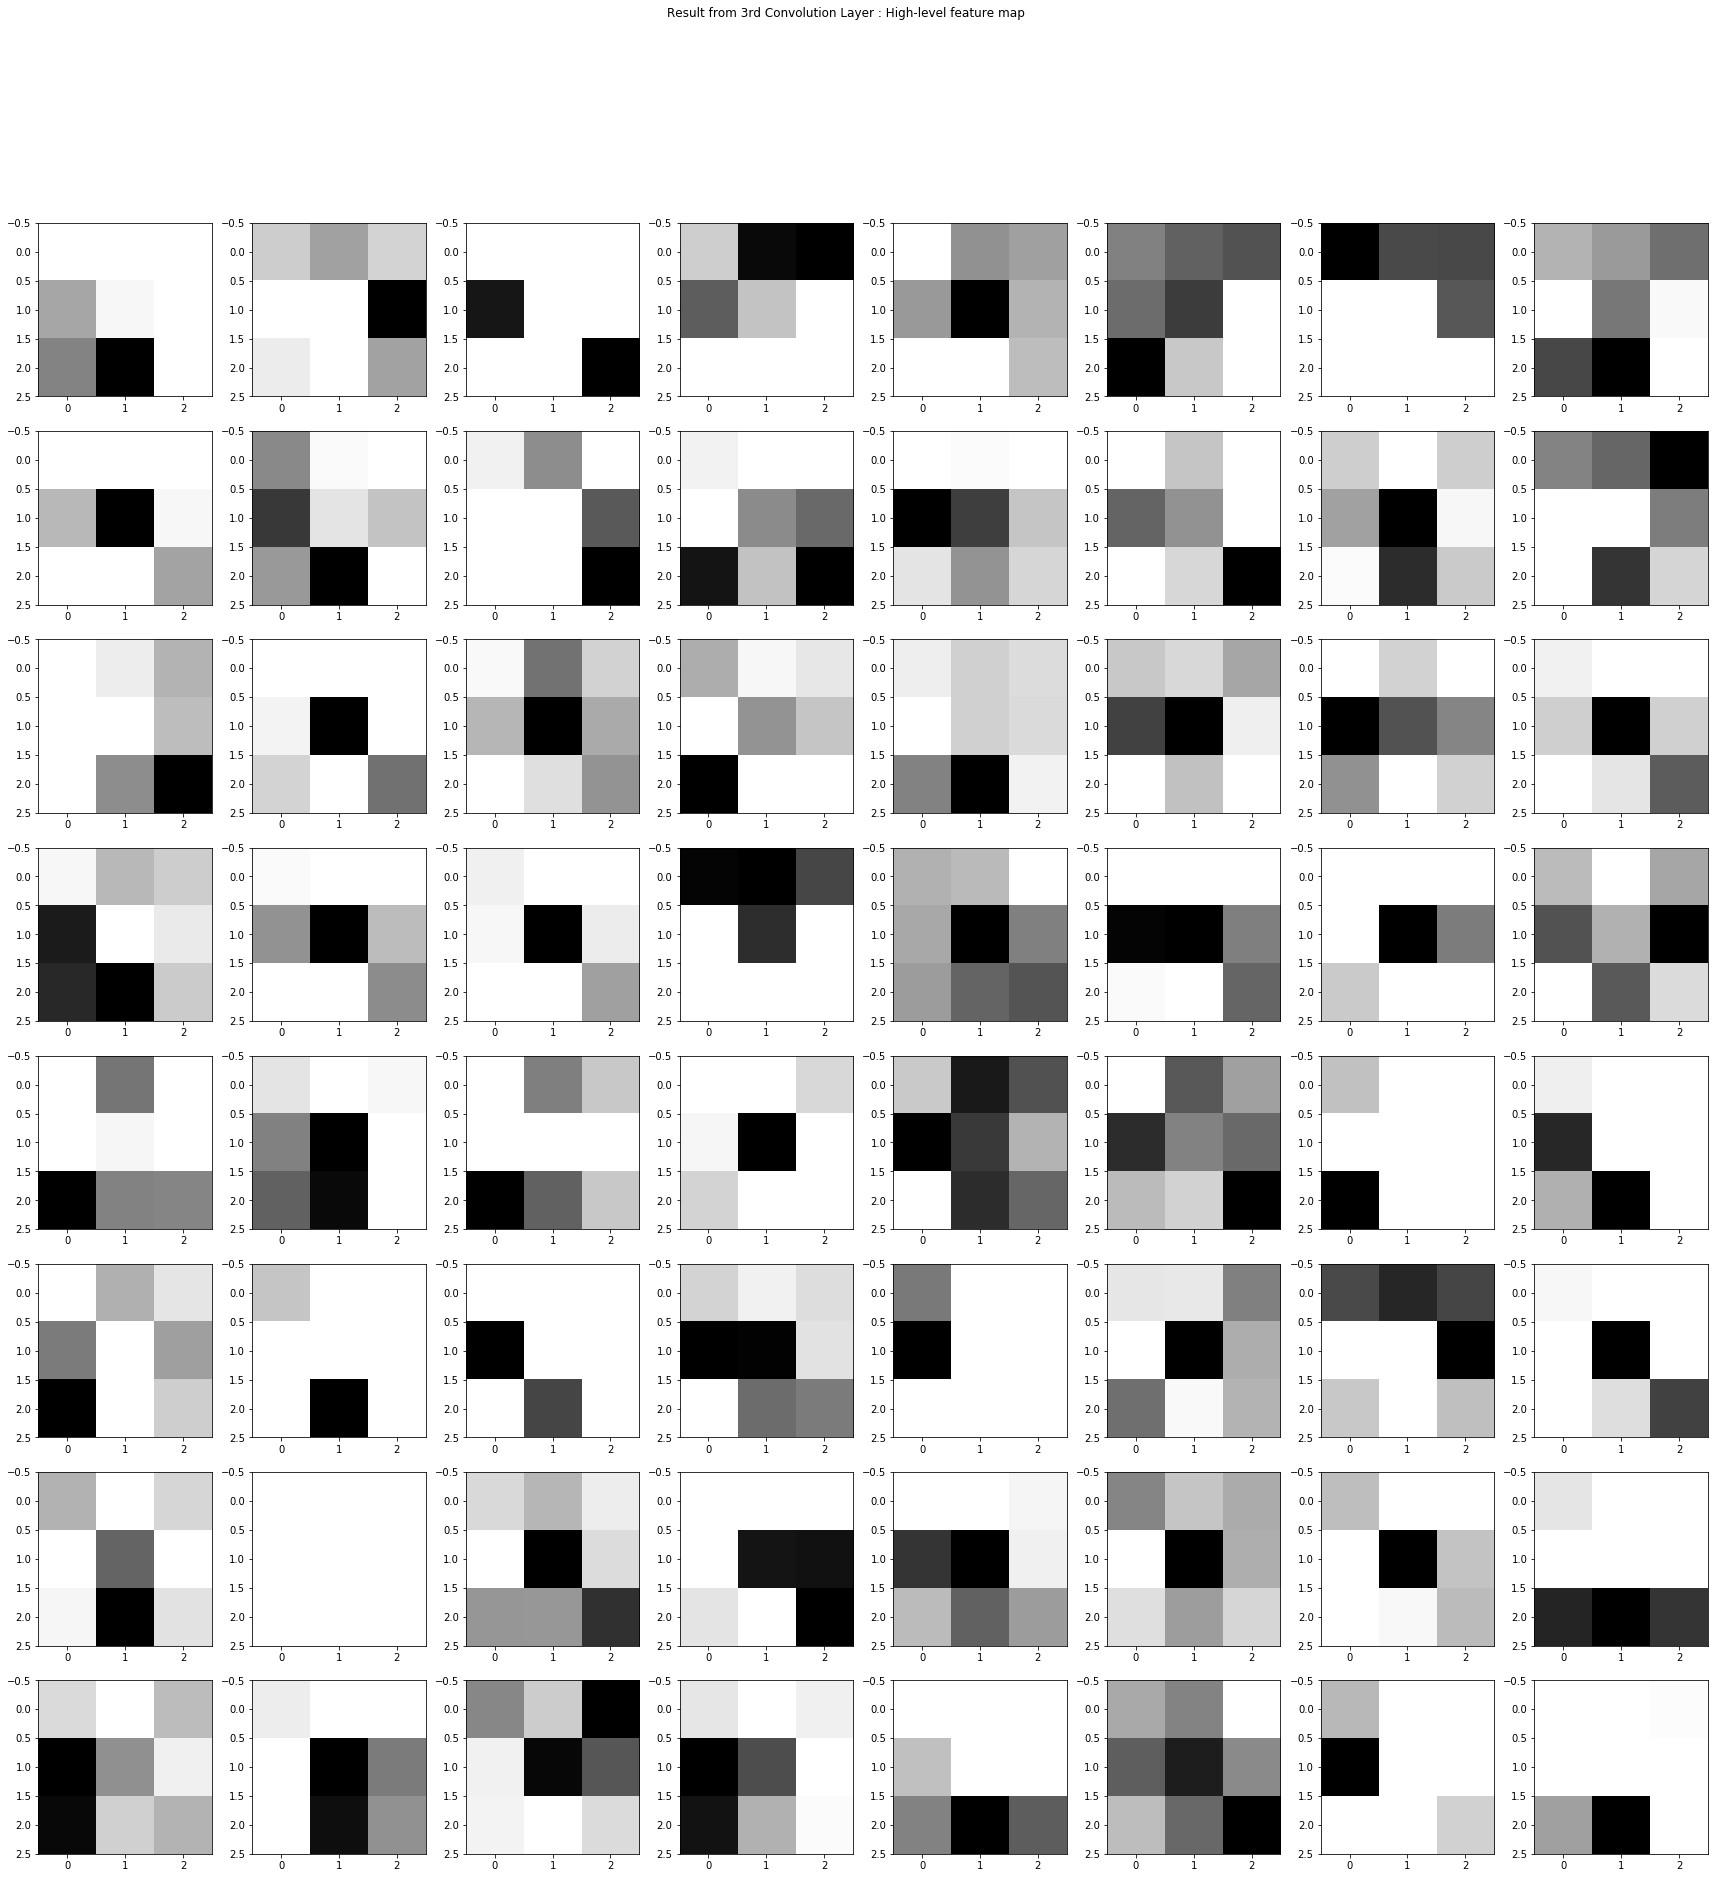

In [13]:
fig_feature3, ax_feature3 = plt.subplots(8,8,figsize=(30,30))
fig_feature3.suptitle("Result from 3rd Convolution Layer : High-level feature map")
ret_pool3 = np.transpose(ret_pool3,axes=(0,3,1,2))
for idx in range(64):
  ax_feature3[idx//8][idx%8].imshow(ret_pool3[0][idx],cmap="binary")